## Fractional Brownian Motion


### Bibliography & References
- https://en.wikipedia.org/wiki/Fractional_Brownian_motion
- https://github.com/732jhy/Fractional-Brownian-Motion [Justin Hu]
- https://hagerpa.github.io/talks/excersize_sheet_sampling_of_fBm.pdf [Paul P. Hager] 
- http://www.columbia.edu/~ad3217/fbm/thesisold.pdf [Ton Dieker]
- https://math.berkeley.edu/~alanmh/papers/fsrwfbm.pdf [Alan Hammond and Scott Sheffield]
- https://re.public.polimi.it/bitstream/11311/1181154/2/A_Fractional_Brownian_Motion_Model_for_Forecasting_Lost_Load_and_Time_Interval_Between_Power_Outages.pdf [Enrico Zio, Carlo Cattani et al.]

**Single path implementation**

In [1]:
import numpy as np
from numpy.fft import fft, ifft
from math import sqrt

def fractional_brownian_motion(x0, n, dt, H, delta=1.0, out=None, rng=None):
    """
    Generates a fractional Brownian motion B_H(t) with Hurst parameter H.
    Uses Davies–Harte to generate fractional Gaussian noise (FGN) and accumulates it.

    Parameters
    ---------
    x0 : float or array-like
        Initial value (or vector of initial conditions).
    n : int
        Number of steps.
    dt : float
        Time step.
    H : float in (0,1)
        Hurst parameter. H=0.5 -> classical Brownian motion.
    delta : float
        Volatility scale (default=1.0).
    out : array or None
        If given, array where to save the path.
    rng : np.random.Generator optional

    Returns
    -------
    out : array with fBM path(s). Has the same shape as x0 with axis -1 of length n+1.

    """
    if rng is None:
        rng = np.random.default_rng()

    x0 = np.asarray(x0)
    shape = x0.shape + (n+1,)

   
    # Fractional-Gaussian Noise Covariance
    k = np.arange(0, n)
    gamma = 0.5 * (np.abs(k+1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k-1)**(2*H))
    ce = np.concatenate([gamma, [0.0], gamma[1:][::-1]])
    lam = np.real(fft(ce))
    if np.any(lam < -1e-12):
        raise RuntimeError("Autocovariance function is not PSD. Davies–Harte failed.")

        
    # Generating FGN with FFT
    m = len(lam)
    W = rng.normal(size=m) + 1j * rng.normal(size=m)
    W[0] = rng.normal()
    W[m//2] = rng.normal()
    W[m//2+1:] = np.conj(W[1:m//2][::-1])

    fgn = ifft(np.sqrt(lam/m) * W).real[:n]
    fgn = delta * (dt**H) * fgn  # time scale and volatility


    # Cumulated Sum
    if out is None:
        out = np.empty(shape)
    out[..., 0] = x0
    out[..., 1:] = x0[..., None] + np.cumsum(fgn, axis=-1)

    return out

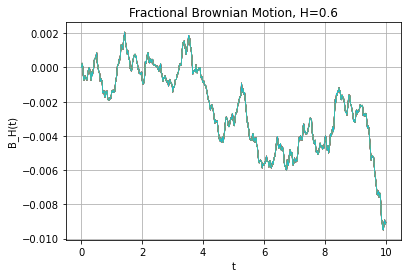

In [2]:
import numpy as np
from pylab import plot, show, grid, xlabel, ylabel, title

delta = 2.0
T = 10.0
N = 500
dt = T / N
m = 20
H = 0.6  # H=0.5 -> Standard Brownian Motion; H>0.5 PCI, smooth lines; H<0.5 NCI, noisy lines

x0 = np.full(m, 0.0)  # m initial conditions
x = fractional_brownian_motion(x0, N, dt, H, delta)

t = np.linspace(0.0, T, N+1)
for k in range(m):
    plot(t, x[k], lw=0.8)

title(f"Fractional Brownian Motion, H={H}")
xlabel('t')
ylabel('B_H(t)')
grid(True)
show()

**Multi-path implementation**

In [3]:
import numpy as np
from numpy.fft import fft, ifft

def fractional_brownian_motion_multi(m, n, T, H, delta=1.0, x0=0.0, rng=None):
    """
    Generates m trajectories of fractional Brownian motion B_H(t) with Hurst parameter H.
    Uses Davies–Harte and generates all trajectories in parallel.

    Parameters
    ---------
    m : int
        Number of independent trajectories.
    n : int
        Number of steps.
    T : float
        Time horizon [0, T].
    H : float in (0,1)
        Hurst parameter. H=0.5 -> classical Brownian motion.
    delta : float
        Volatility scale (default=1.0).
    x0 : float
        Initial value of each trajectory (default=0.0).
    rng : np.random.Generator optional

    Returns
    -------
    t : array shape (n+1,)
            Time grid.
    paths : array shape (m, n+1)
            fBM trajectories.

    """
    if rng is None:
        rng = np.random.default_rng()

    dt = T / n
    t = np.linspace(0.0, T, n+1)


    # Fractional-Gaussian Noise Covariance Increments
    k = np.arange(0, n)
    gamma = 0.5 * (np.abs(k+1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k-1)**(2*H))
    ce = np.concatenate([gamma, [0.0], gamma[1:][::-1]])
    lam = np.real(fft(ce))
    if np.any(lam < -1e-12):
        raise RuntimeError("Autocovarianza non PSD: Davies–Harte fallito.")

    m2 = len(lam)


    # Gaussian noise for m trajectories
    Z = rng.normal(size=(m, m2)) + 1j * rng.normal(size=(m, m2))
    Z[:, 0] = rng.normal(size=m)
    Z[:, m2//2] = rng.normal(size=m)
    Z[:, m2//2+1:] = np.conj(Z[:, 1:m2//2][:, ::-1])


    # Generating FGN with FFT
    sqrt_lam = np.sqrt(lam / m2)
    FGN = ifft(sqrt_lam * Z, axis=1).real[:, :n]
    FGN *= delta * (dt**H) # time scale and volatility


    # Cumulated Sum
    paths = np.zeros((m, n+1))
    paths[:, 0] = x0
    paths[:, 1:] = x0 + np.cumsum(FGN, axis=1)

    return t, paths

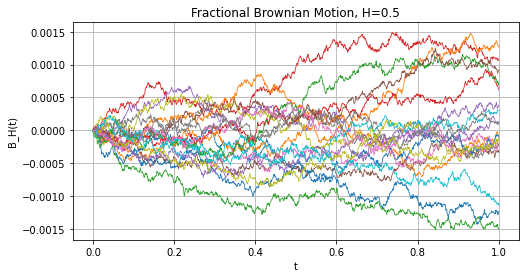

In [4]:
import matplotlib.pyplot as plt

# Parameters
m = 20        # number of trajectories
n = 1000      # steps
T = 1.0       # time to maturity (final time)
H = 0.5       # Hurst exponent
delta = 1.0   # volatility
x0 = 0.0      # starting value

t, paths = fractional_brownian_motion_multi(m, n, T, H, delta, x0)

# Plot
plt.figure(figsize=(8,4))
for k in range(m):
    plt.plot(t, paths[k], lw=0.8)
plt.title(f"Fractional Brownian Motion, H={H}")
plt.xlabel("t")
plt.ylabel("B_H(t)")
plt.grid(True)
plt.show()